## Preamble

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from pygam import s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM

from ISLP import load_data
from ISLP.models import summarize, poly, ModelSpec as MS, bs, ns
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.pygam import approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

from sklearn.model_selection import train_test_split

precision=3
# np.set_printoptions(precision=precision)
pd.set_option('display.precision', precision)
# pd.set_option('styler.format.thousands', '{:,}')
# pd.reset_option('display.precision')

sns.set();
# sns.palplot(sns.color_palette("muted"));
# sns.light_palette("seagreen", n_colors=6);
# sns.dark_palette("purple", n_colors=6);

### Utilities

#### Plotting

In [2]:
def plot_fit(data, feature, target, basis, title, ax=None):
    feat = data.loc[:, feature]

    # test data
    tdata = pd.DataFrame({feature: np.linspace(feat.min(), feat.max(), 100)})
    
    X, y = basis.transform(data), data.loc[:, target]
    Xnew = basis.transform(tdata)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    # 95% confidence interval
    bands = preds.conf_int(alpha=0.05)
    
    ax.scatter(
        feat, y,
        facecolor='gray',
        alpha=0.2
    )
    
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],['b','r--','r--']):
        ax.plot(tdata.values, val, ls, linewidth=3)

    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel(target)

    return ax
    

## Wage

In [3]:
Wage = load_data('Wage')
Wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318,75.043
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255,70.476
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875,130.982
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041,154.685
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318,75.043
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041,154.685
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602,99.689
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193,66.229
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477,87.981


### Predicting wage

Predicting wage using age.

In [4]:
y = Wage.loc[:, 'wage']
age = Wage.loc[:, 'age']
y.shape, age.shape

((3000,), (3000,))

In [5]:
poly_age = MS([poly('age', degree=4)])
M = sm.OLS(y, poly_age.fit_transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.704,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.068,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.316,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.522,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.911,39.915,-1.952,0.051


#### ANOVA

ANOVA test on 4-degree polynomial.

In [6]:
models = [MS([poly('age', degree=x)]) for x in range(1, 5)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793e+06,1.0,228786.010,143.602,2.353e-32
2,2996.0,4.778e+06,1.0,15755.694,9.889,1.679e-03
3,2995.0,4.772e+06,1.0,6070.152,3.810,5.104e-02


#### Cross-validation

Cross-validation on 4-degree polynomial.

In [7]:
def evalMSE(ms, target, train, test):
    X_train = ms.fit_transform(train)
    y_train = train[target]

    X_test = ms.transform(test)
    y_test = test[target]

    results = sm.OLS(y_train, X_train).fit()
    y_hat = results.predict(X_test)

    # squared residuals
    sqresid = (y_test - y_hat)**2
    
    # residual sum of squares (RSS)
    rss = np.sum(sqresid)

    return rss, np.mean(sqresid)

In [8]:
# 80/20 train/test split
Wage_train, Wage_test = train_test_split(Wage, test_size=.2, random_state=42)

poly_ages = [MS([poly('age', degree=x)]) for x in range(1, 5)]

mse = []
for i in range(0, len(poly_ages)):
    mse.append((i+1, evalMSE(poly_ages[i], 'wage', Wage_train, Wage_test)))

mse

[(1, (910867.2391353506, 1518.1120652255843)),
 (2, (867045.5304217574, 1445.0758840362623)),
 (3, (866201.1569357711, 1443.668594892952)),
 (4, (863801.5094456237, 1439.669182409373))]

Based on the results above, 4-degrees is the simplest model with minimal MSE.

#### Plots

We plot the fit of all polynomials.

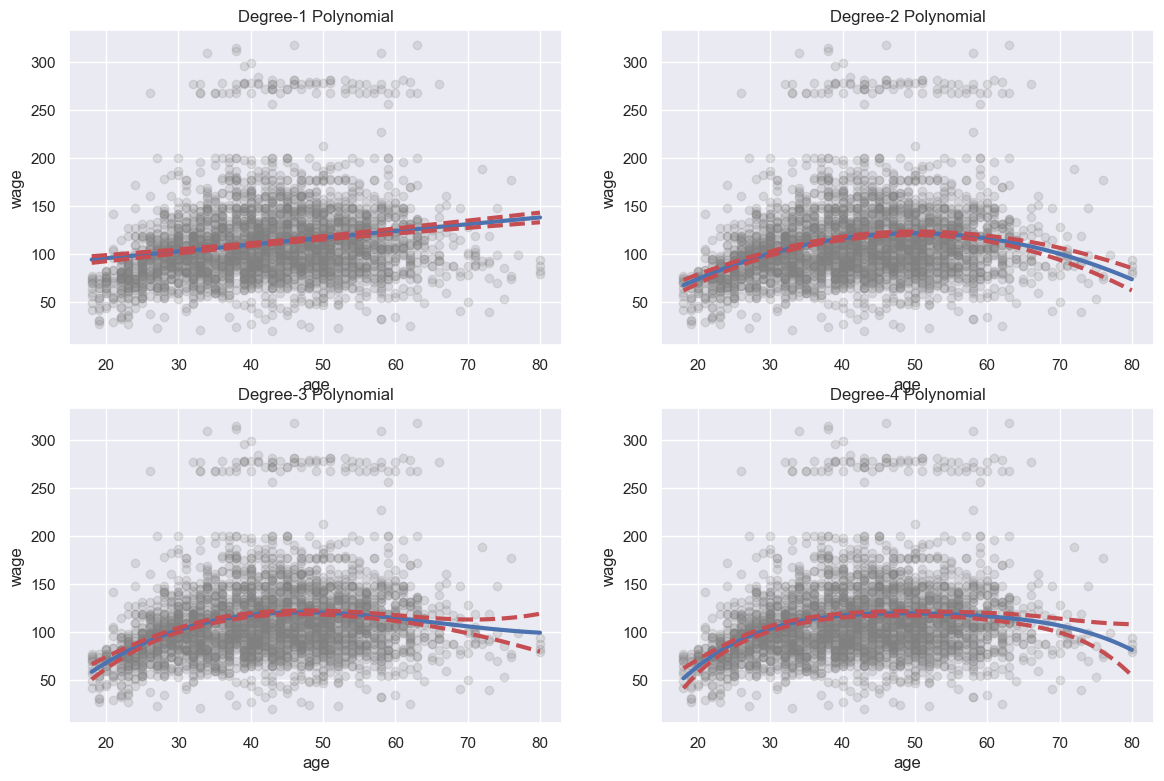

In [9]:
poly_age_grid = np.array(poly_ages).reshape((2, 2))
degrees = np.arange(1, 5).reshape((2, 2))
_, axes = plt.subplots(2, 2, figsize=(14, 9))

for i in range(0, 2):
    for j in range (0, 2):
        plot_fit(Wage, 'age', 'wage', poly_age_grid[i][j], f'Degree-{degrees[i][j]} Polynomial', ax=axes[i,j]);

### Step functions

In [10]:
Xage_cut = pd.get_dummies(pd.qcut(age, 4))
pd.concat([Xage_cut, Wage.loc[:, 'wage']], axis='columns')

,"(17.999, 33.75]","(33.75, 42.0]","(42.0, 51.0]","(51.0, 80.0]",wage
0,True,False,False,False,75.043
1,True,False,False,False,70.476
2,False,False,True,False,130.982
3,False,False,True,False,154.685
4,False,False,True,False,75.043
...,...,...,...,...,...
2995,False,False,True,False,154.685
2996,True,False,False,False,99.689
2997,True,False,False,False,66.229
2998,True,False,False,False,87.981


#### Cross-validation

In [11]:
mse = []

for cut in range(2, 11):
    Xage_cut = pd.get_dummies(pd.qcut(age, cut))
    X = pd.concat([Xage_cut, Wage.loc[:, 'wage']], axis='columns')
    X_train, X_test = train_test_split(X, test_size=.2, random_state=42)
    ms = MS(Xage_cut.columns.tolist())
    mse.append((cut, evalMSE(ms, 'wage', X_train, X_test)))

mse

[(2, (931144.8374431285, 1551.9080624052142)),
 (3, (901629.9898532596, 1502.7166497554326)),
 (4, (886641.8289864861, 1477.7363816441434)),
 (5, (890816.6274416135, 1484.6943790693558)),
 (6, (894565.549957104, 1490.9425832618401)),
 (7, (879357.9706287938, 1465.5966177146563)),
 (8, (879297.2397213873, 1465.4953995356454)),
 (9, (878481.4545145914, 1464.135757524319)),
 (10, (875858.8630179515, 1459.7647716965857))]

We can see from above that the lowest MSE is achieved using 10 cuts.

## Auto

In [12]:
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


### Heatmap

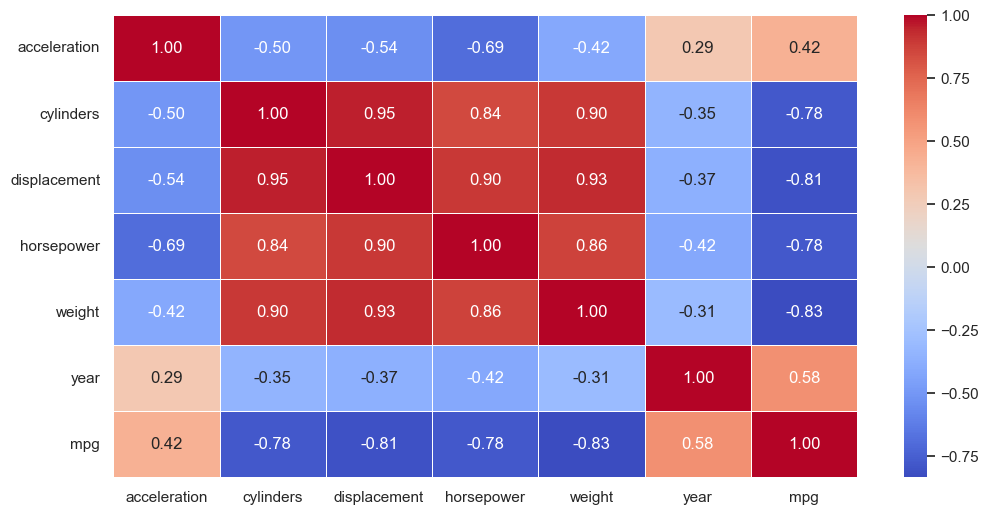

In [13]:
_, ax = plt.subplots(figsize=(12,6))

features = ['acceleration', 'cylinders', 'displacement', 'horsepower', 'weight', 'year', 'mpg']

sns.heatmap(
    Auto.loc[:, features].corr(), 
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f', 
    linewidths=.5, 
    ax=ax
);

### Scatterplot

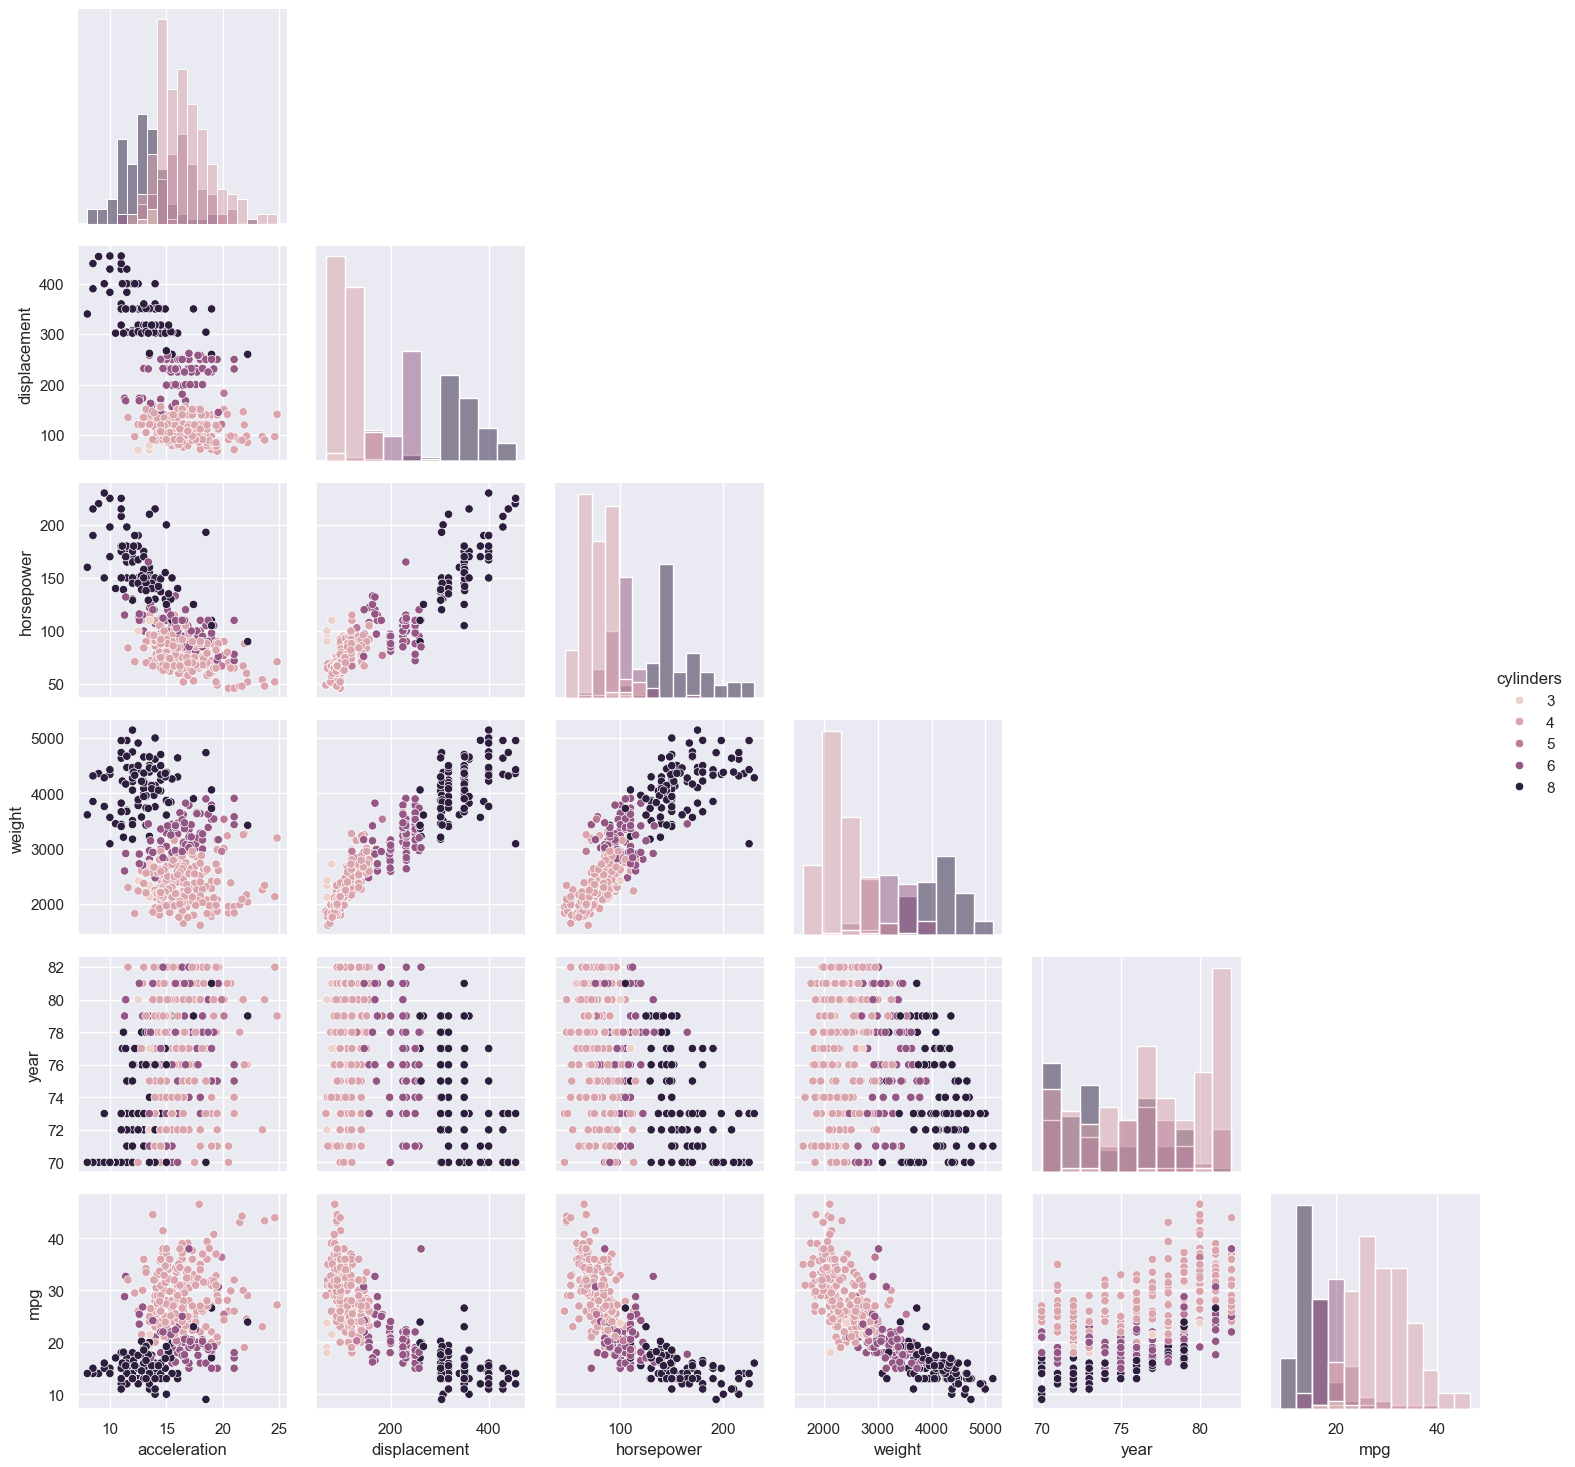

In [14]:
g = sns.PairGrid(Auto.loc[:, features], hue='cylinders', diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

Based on the plot above, `mpg` has non-linear relationship with the following features: weight, horsepower, displacement.

## Boston

In [15]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.006,18.0,2.31,0,0.538,6.575,65.2,4.090,1,296,15.3,4.98,24.0
1,0.027,0.0,7.07,0,0.469,6.421,78.9,4.967,2,242,17.8,9.14,21.6
2,0.027,0.0,7.07,0,0.469,7.185,61.1,4.967,2,242,17.8,4.03,34.7
3,0.032,0.0,2.18,0,0.458,6.998,45.8,6.062,3,222,18.7,2.94,33.4
4,0.069,0.0,2.18,0,0.458,7.147,54.2,6.062,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.063,0.0,11.93,0,0.573,6.593,69.1,2.479,1,273,21.0,9.67,22.4
502,0.045,0.0,11.93,0,0.573,6.120,76.7,2.288,1,273,21.0,9.08,20.6
503,0.061,0.0,11.93,0,0.573,6.976,91.0,2.167,1,273,21.0,5.64,23.9
504,0.110,0.0,11.93,0,0.573,6.794,89.3,2.389,1,273,21.0,6.48,22.0


### Heatmap

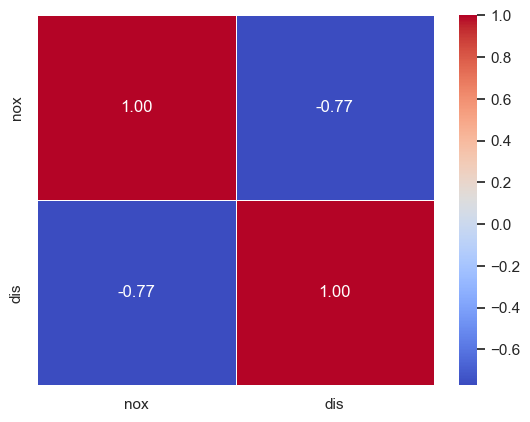

In [16]:
_, ax = plt.subplots()

sns.heatmap(
    Boston.loc[:, ['nox', 'dis']].corr(), 
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f', 
    linewidths=.5, 
    ax=ax
);

### Scatterplot

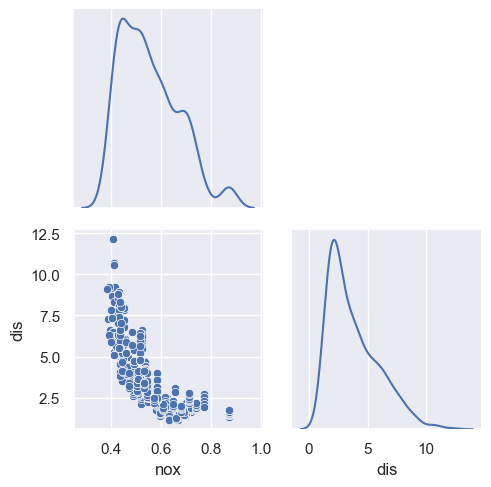

In [17]:
g = sns.PairGrid(Boston.loc[:, ['nox', 'dis']], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot);

### Polynomial regression

In [18]:
y = Boston.loc[:, 'nox']
poly_dis = MS([poly('dis', degree=3)])
M = sm.OLS(y, poly_dis.fit_transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.555,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.003,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.856,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.318,0.062,-5.124,0.0


#### Cross-validation

In [19]:
# 80/20 train/test split
Boston_train, Boston_test = train_test_split(Boston, test_size=.2, random_state=42)

poly_diss = [MS([poly('dis', degree=x)]) for x in range(1, 11)]

mse = []
for i in range(0, len(poly_diss)):
    mse.append((i+1, evalMSE(poly_diss[i], 'nox', Boston_train, Boston_test)))

mse

[(1, (0.5186974282635589, 0.005085268904544696)),
 (2, (0.3357057536306356, 0.0032912328787317213)),
 (3, (0.32479570226668847, 0.003184271590849887)),
 (4, (0.3328421623100179, 0.0032631584540197835)),
 (5, (0.32318616189958704, 0.0031684917833292845)),
 (6, (0.31636416098035985, 0.003101609421376077)),
 (7, (0.32278670659861425, 0.003164575554888375)),
 (8, (0.3225621014460622, 0.003162373543588845)),
 (9, (0.32260244270854066, 0.0031627690461621632)),
 (10, (0.32713255050241624, 0.0032071818676707477))]

#### Plots

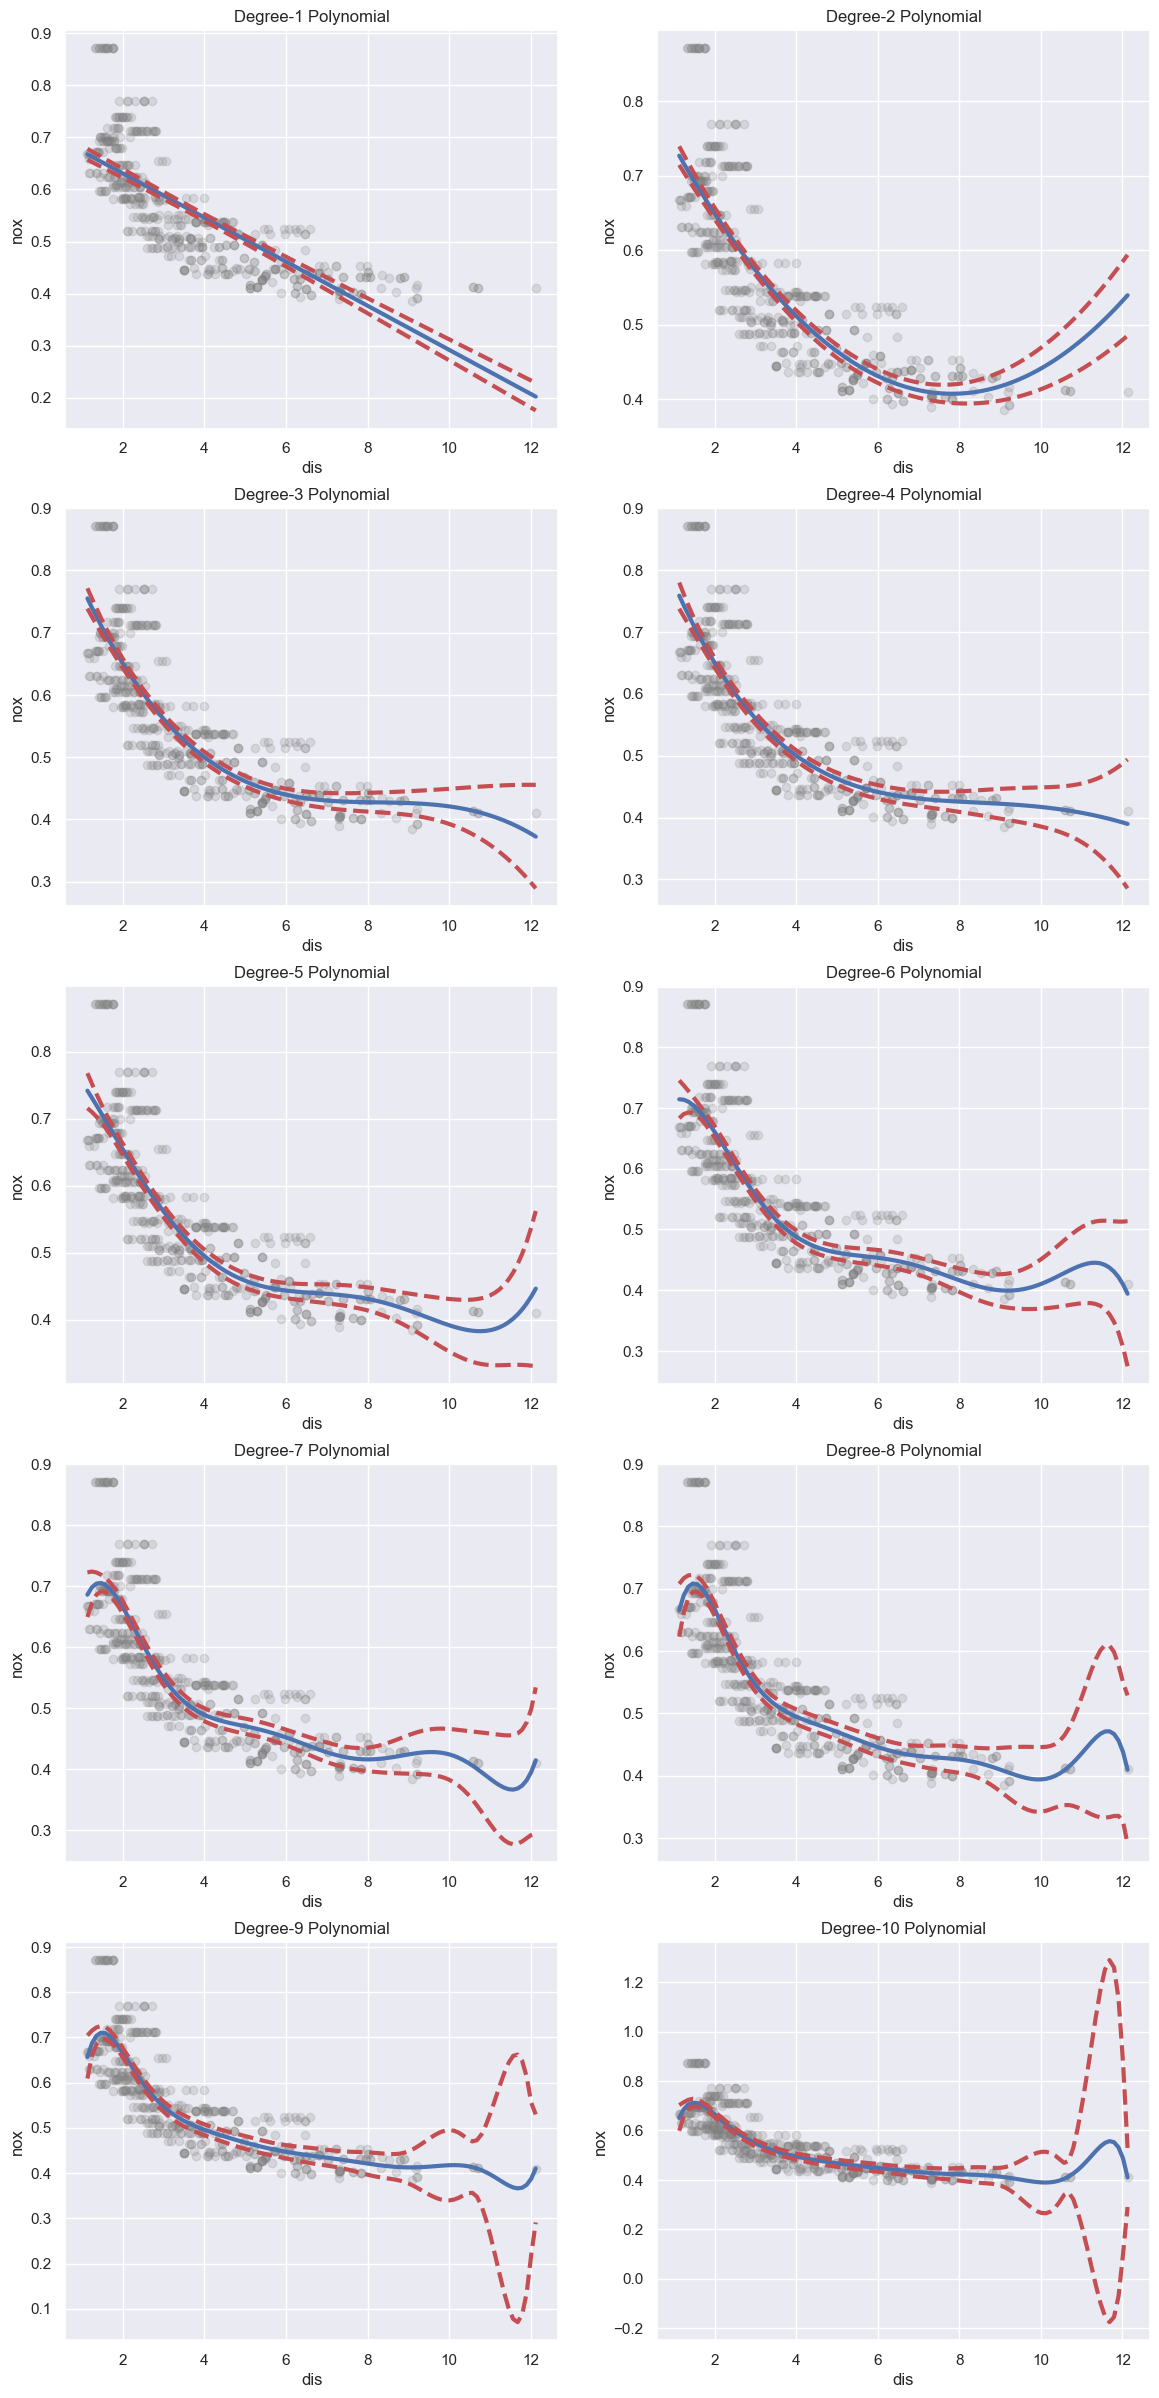

In [20]:
poly_dis_grid = np.array(poly_diss).reshape((5,2))
degrees = np.arange(1, 11).reshape((5, 2))
_, axes = plt.subplots(5, 2, figsize=(14, 30))

for i in range(0, 5):
    for j in range (0, 2):
        plot_fit(Boston, 'dis', 'nox', poly_dis_grid[i][j], f'Degree-{degrees[i][j]} Polynomial', ax=axes[i,j]);

The above plot suggests that we achieve a good fit using 3-4 degrees of polynomial. It's also noticeable that the confidence itervals are wider at the tail end.

### Regression spline

In [21]:
y = Boston.loc[:, 'nox']
bs_dis = MS([bs('dis', df=3)])
M = sm.OLS(y, bs_dis.fit_transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.755,0.008,91.168,0.0
"bs(dis, df=3)[0]",-0.498,0.033,-15.312,0.0
"bs(dis, df=3)[1]",-0.234,0.037,-6.312,0.0
"bs(dis, df=3)[2]",-0.383,0.045,-8.419,0.0


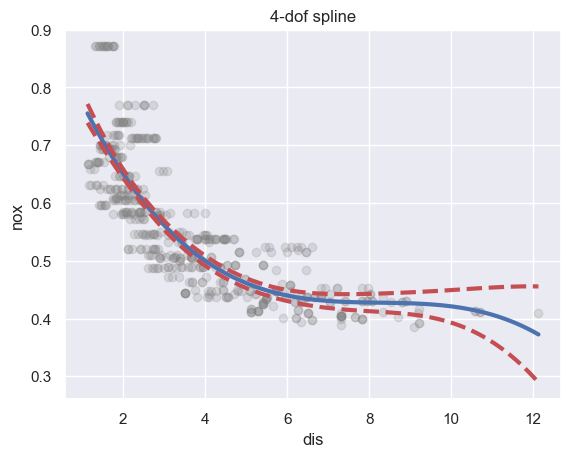

In [22]:
_, ax = plt.subplots()

plot_fit(Boston, 'dis', 'nox', bs_dis, f'4-dof spline', ax=ax);

#### Cross-validation

In [23]:
bs_diss = [MS([bs('dis', df=x)]) for x in range(3, 9)]

mse = []
for i in range(0, len(bs_diss)):
    mse.append((i+3, evalMSE(bs_diss[i], 'nox', Boston_train, Boston_test)))

mse

[(3, (0.3247957022666884, 0.0031842715908498866)),
 (4, (0.3190004196808738, 0.0031274550949105273)),
 (5, (0.3163555531841214, 0.0031015250312168762)),
 (6, (0.3233440567830758, 0.003170039772383096)),
 (7, (0.33054919473481975, 0.0032406783797531346)),
 (8, (0.34070643390280586, 0.0033402591559098613))]

#### Plots

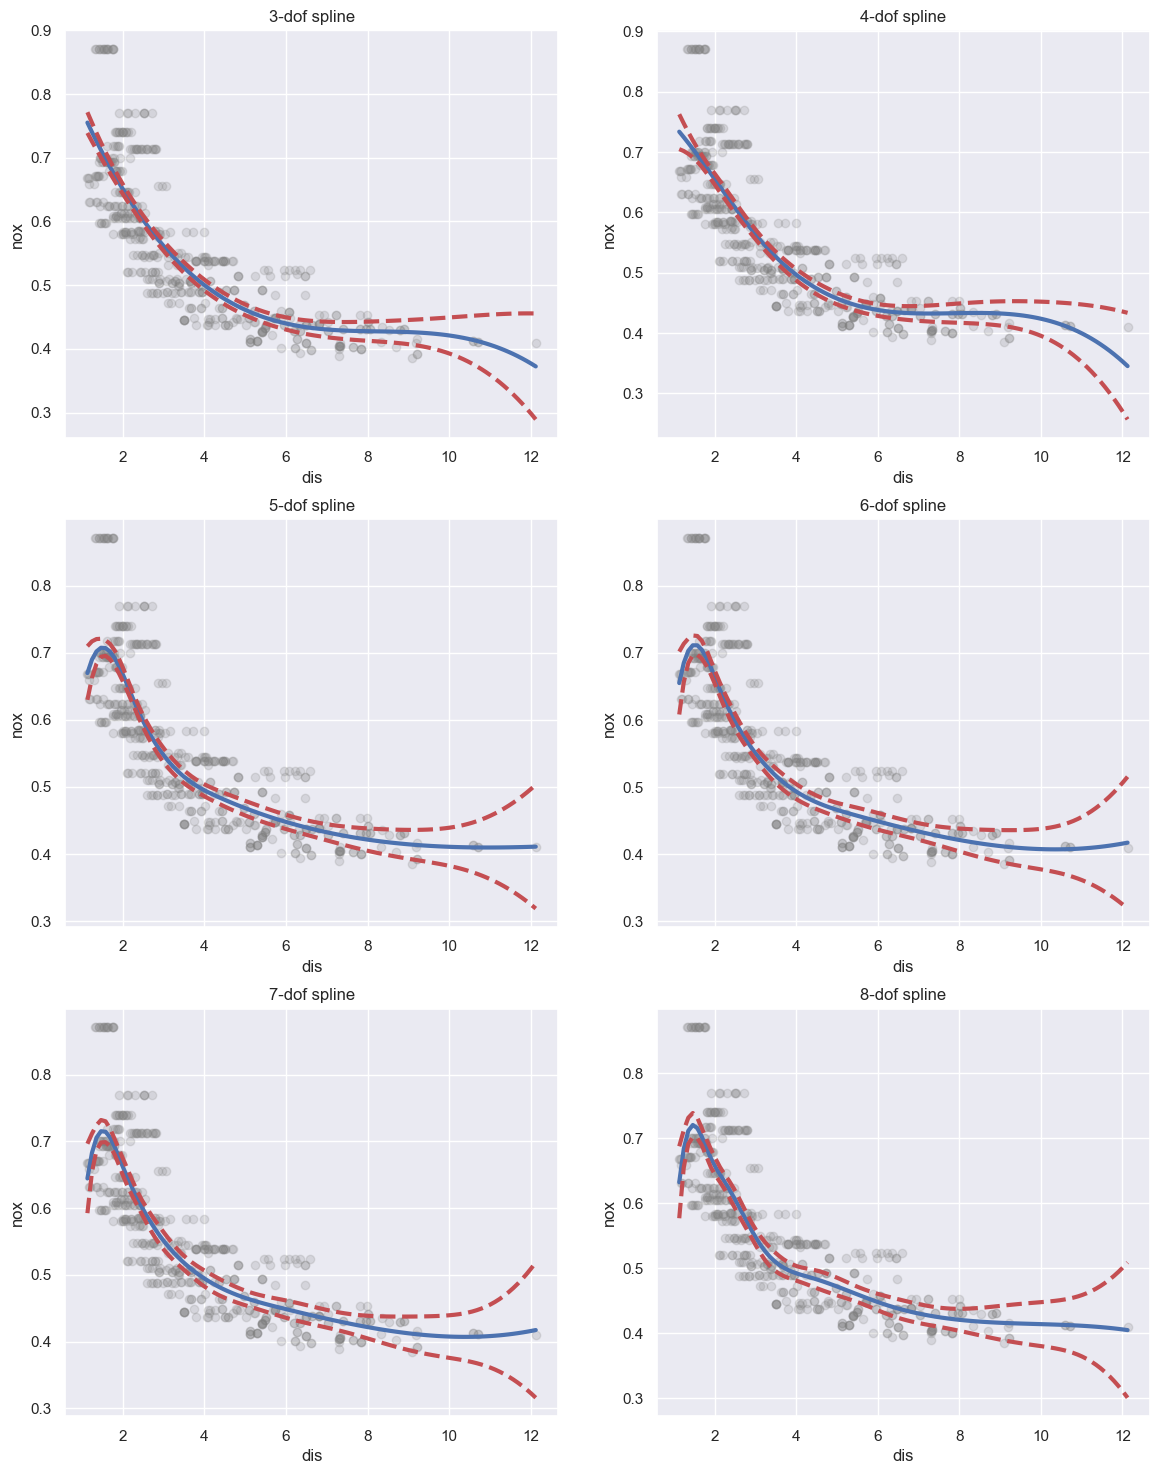

In [24]:
bs_dis_grid = np.array(bs_diss).reshape((3,2))
dofs = np.arange(3, 9).reshape((3, 2))
_, axes = plt.subplots(3, 2, figsize=(14, 18))

for i in range(0, 3):
    for j in range (0, 2):
        plot_fit(Boston, 'dis', 'nox', bs_dis_grid[i][j], f'{dofs[i][j]}-dof spline', ax=axes[i,j]);

We can see from the above plots that 3-4 dof spline seems to have the best fit. 5-8 dof seems to develop a small front "tail", similar to the one in poly. Unlike poly, the spline don't look as wiggly and the tail end don't look as "wild" as the poly.

## College

In [41]:
College = load_data('College')
College.shape

(777, 18)

### Heatmap

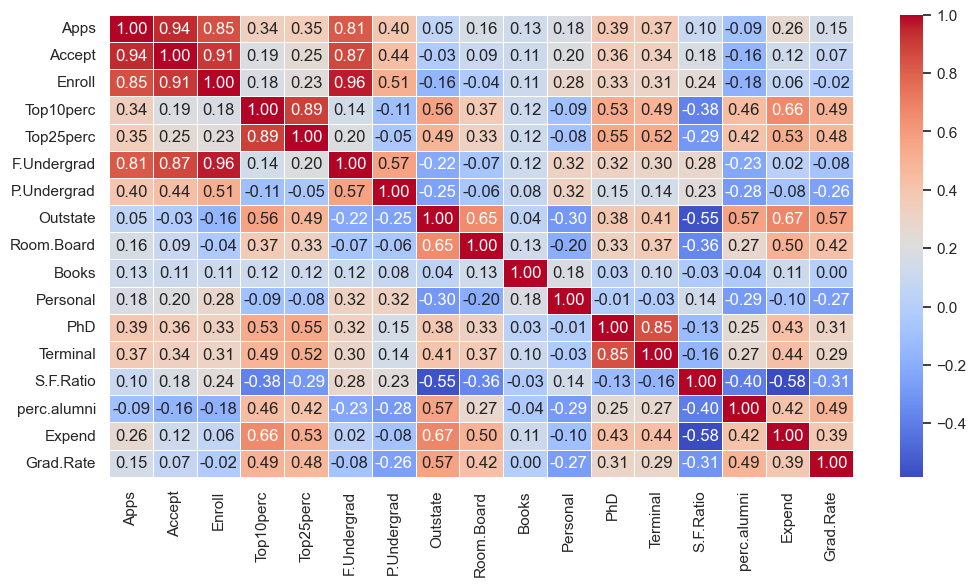

In [26]:
_, ax = plt.subplots(figsize=(12,6))

features = College.columns.drop(['Private']).tolist()

sns.heatmap(
    College.loc[:, features].corr(), 
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f', 
    linewidths=.5, 
    ax=ax
);

### Stepwise selection

In [27]:
College_train, College_test = train_test_split(College, test_size=.33, random_state=42)
College_train.shape, College_test.shape

((520, 18), (257, 18))

In [28]:
y_train, y_test = College_train['Outstate'], College_test['Outstate']
y_train.shape, y_test.shape

((520,), (257,))

In [29]:
College_features = College.columns.drop('Outstate').tolist()
len(College_features)

17

In [30]:
college_ms = MS(College_features).fit(College_train)
strategy = Stepwise.fixed_steps(college_ms, len(college_ms.terms), direction='forward')
full_path = sklearn_selection_path(sm.OLS, strategy, cv=5)
full_path

,model_type,<class 'stats...ar_model.OLS'>
,strategy,"Strategy(init...b2d9ee0>, 17))"
,model_args,{}
,scoring,None
,cv,5


In [31]:
full_path.fit(College_train, y_train)
yhat_in = full_path.predict(College_test)
yhat_in.shape

(257, 18)

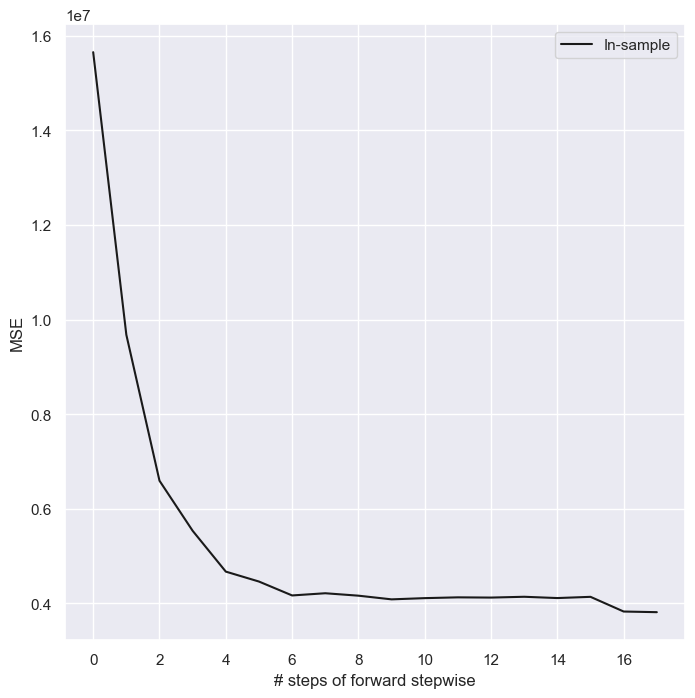

In [32]:
_, ax = plt.subplots(figsize=(8,8))

insample_mse = ((yhat_in - np.array(y_test)[:, np.newaxis])**2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    'k', # color black
    label='In-sample'
)
ax.set_ylabel('MSE')
ax.set_xlabel('# steps of forward stepwise')
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend();

The results above suggests that MSE from 6 to 15 looks flat, so we might be better using the simplest model with the smallest MSE.

In [42]:
features, _, result = full_path.models_[6]
selected_features = [feature.name for feature in features]
selected_features

['Expend', 'Grad.Rate', 'PhD', 'Private', 'Room.Board', 'perc.alumni']

In [43]:
summarize(result)

,coef,std err,t,P>|t|
intercept,-3717.102,535.157,-6.946,0.000
Expend,0.220,0.022,10.114,0.000
Grad.Rate,20.290,6.497,3.123,0.002
PhD,40.877,6.999,5.840,0.000
Private[Yes],2826.260,254.141,11.121,0.000
Room.Board,1.046,0.102,10.223,0.000
perc.alumni,50.044,9.401,5.323,0.000


### GAM

In [46]:
X_train = MS(selected_features, intercept=False).fit_transform(College_train)
X_train.shape

(520, 6)

In [45]:
Xgam_train = np.array(X_train)
Xgam_train.shape

(520, 6)

In [38]:
gam = LinearGAM(s_gam(0) + 
                s_gam(1) + 
                s_gam(2) + 
                f_gam(3) + 
                s_gam(4) + 
                s_gam(5))

gam_results = gam.fit(X_train, y_train)
gam_results

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + f(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

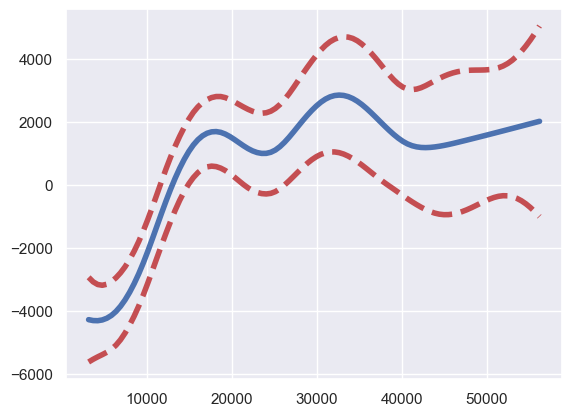

In [39]:
_, ax = plt.subplots()
plot_gam(gam_results, 0, ax=ax);

### Pair plots

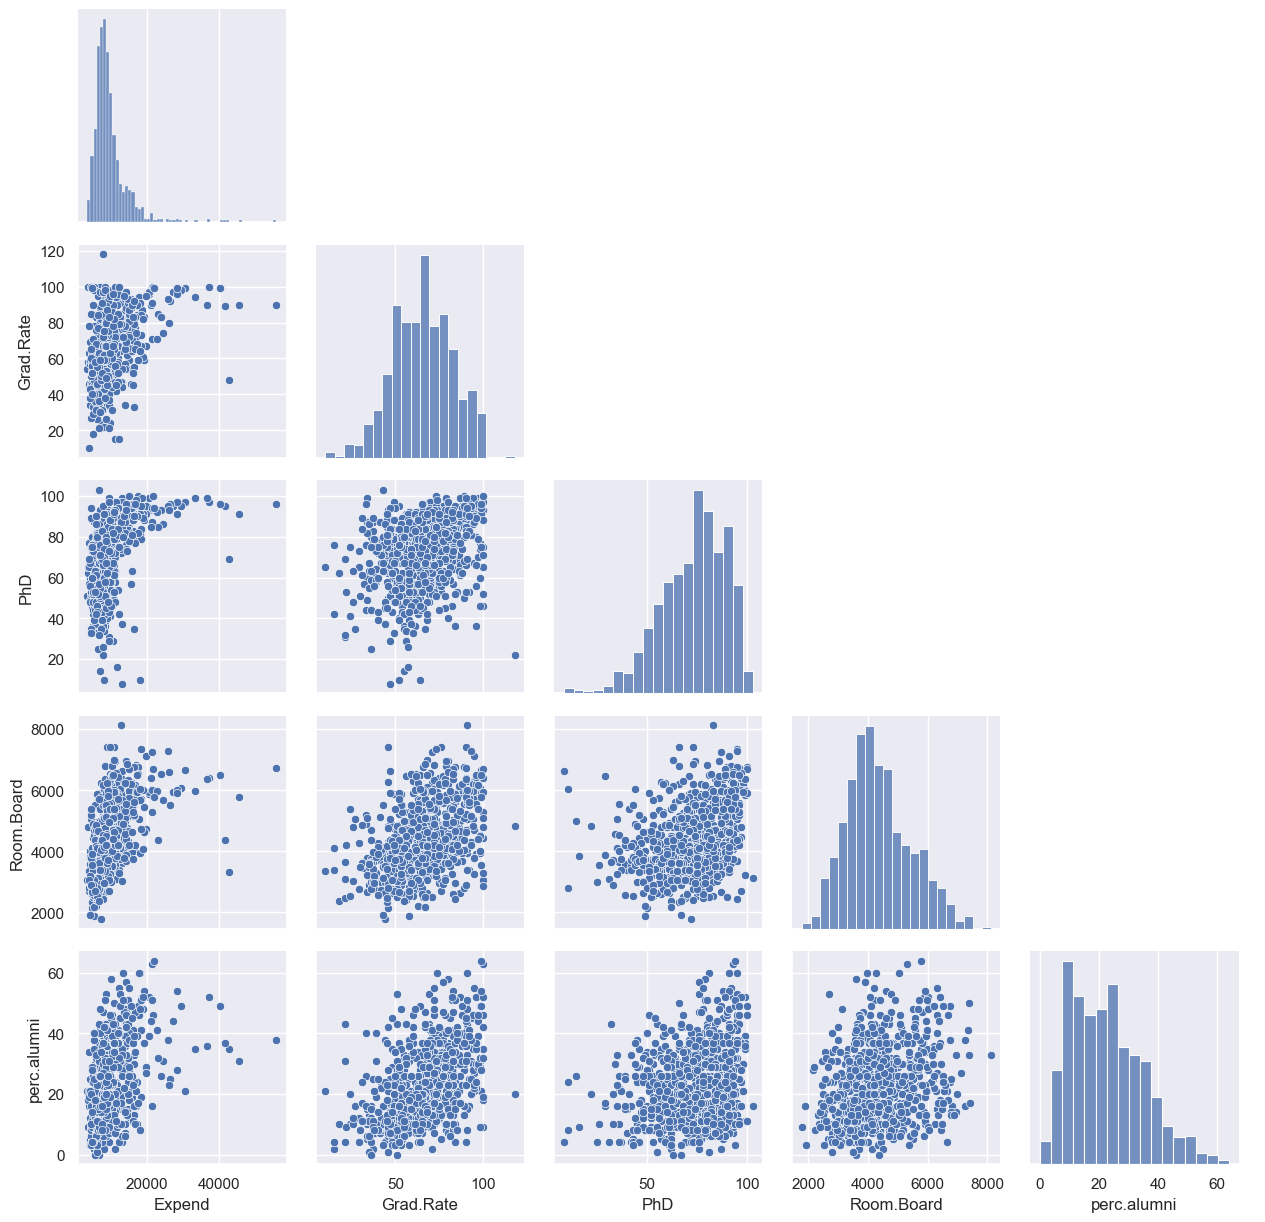

In [40]:
g = sns.PairGrid(College.loc[:, selected_features], diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

## Backfitting

Todo: implement backfitting